# Introduction

Washington, D.C. has communal bike sharing stations where you can rent bicycles by the hour or day. The District collects detailed data on the number of bicycles people rent by the hour and day.

[Hadi Fanaee-T](http://www.fanaee.com/) now at the University of Oslo, Norway compiled this data into a CSV file for this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. The data can be found from the [University of California, Irvine's website](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

I will try to predict the total number of bikes people rented in a given hour. I will predict the `cnt` column using all of the other columns, except for `casual` and `registered`. To accomplish this, I will create a few different machine learning models and evaluate their performance.


> Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues.
>
> Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

| Column Name | Description                                                                                                                                 |
|-------------|---------------------------------------------------------------------------------------------------------------------------------------------|
| instant     | record index                                                                                                                                |
| dteday      | date                                                                                                                                        |
| season      | season (1: winter, 2: spring, 3: summer, 4: fall)                                                                                               |
| yr          | year (0: 2011, 1: 2012)                                                                                                                      |
| mnth        | month (1 to 12)                                                                                                                            |
| hr          | hour (0 to 23)                                                                                                                              |
| holiday     | weather day is holiday or not                                                                                   |
| weekday     | day of the week                                                                                                                             |
| workingday  | if day is neither weekend nor holiday is 1, otherwise is 0                                                                                  |
| weathersit  | 1: Clear, Few clouds, Partly cloudy, Partly cloudy                                                                                          |
|             | 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                                                                             |
|             | 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds                                                  |
|             | 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog                                                                               |
| temp        | Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)           |
| atemp       | Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)  |
| hum         | Normalized humidity. The values are divided to 100 (max)                                                                                    |
| windspeed   | Normalized wind speed. The values are divided to 67 (max)                                                                                   |
| casual      | count of casual users                                                                                                                       |
| registered  | count of registered users                                                                                                                   |
| cnt         | count of total rental bikes including both casual and registered                                                                            |


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import joblib

pd.options.display.max_columns = 20
plt.style.use('fivethirtyeight')

In [22]:
bike_rentals = pd.read_csv('data/hour.csv')
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.2+ MB


# Exploration

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


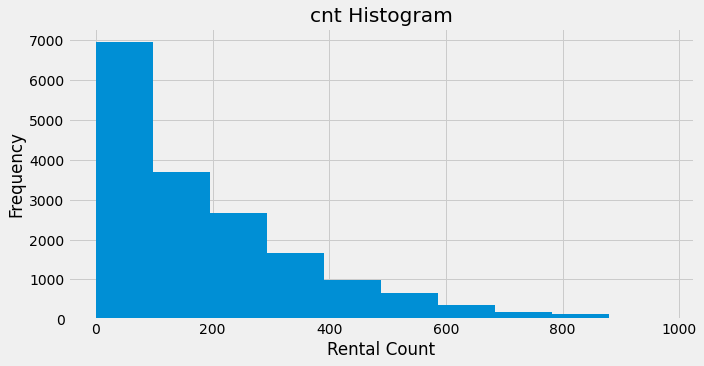

In [23]:
display(bike_rentals.head())

plt.figure('cnthist', figsize=(10,5))
bike_rentals['cnt'].hist()
plt.title('cnt Histogram')
plt.xlabel('Rental Count')
plt.ylabel('Frequency')
plt.show()

In [24]:
bike_rentals.corr()['cnt'].sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

# Changing Labels

The time columns are not very useful as just numbers. If they were categorized with labels then we can generalize the trends of those specific time periods.

In [25]:
def label_hour(hour):
    if (hour < 0) | (hour > 24):
        return -1
    elif (hour < 6):
        return 4
    elif (hour < 12):
        return 1
    elif (hour < 18):
        return 2
    else:
        return 3

In [26]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(label_hour)
bike_rentals['time_label'].describe()

count    17379.000000
mean         2.492548
std          1.115284
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: time_label, dtype: float64

In [27]:
bike_rentals['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

Mean Squared Error may be the easiest error metric to measure my model's prediction accuracy of the `cnt` column. The column is continuous and numeric which fits well for MSE.

In [28]:
train = bike_rentals.sample(frac=.8)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

Linear Regression may not be the best model suited for `cnt` as it does not have an compelling correlation to most of the other columns, but it is the simplest. I will build a Linear Model first, and then develop a random forest from a decision tree.

In [29]:
nothelpful = ['cnt', 'casual', 'registered', 'dteday', 'instant']
features = ['hr', 'holiday', 'workingday', 'weathersit', 'atemp', 'temp']
lr = LinearRegression()

These are the features I think will be most helpful in predicting `cnt` without any further manipulation. Some of the weather descriptors should be rearranged for a more direct correlation. For example, I believe that most people would like to ride their bike in good moderate weather: sunny, clear skies, low to medium humidity, moderate temperatures, low windspeed, and during the day. The prediction accuracy would increase if there was a way to combine these columns into a score.

In [30]:
lr.fit(train[features], train['cnt'])
predictions = lr.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)
print('MSE: {0:.3f}'.format(mse))

MSE: 23908.951


In [31]:
features = bike_rentals.columns.drop(nothelpful)

lr.fit(train[features], train['cnt'])
predictions = lr.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)
print('MSE: {0:.3f}'.format(mse))

MSE: 17630.497


In [32]:
cnt_corr = bike_rentals.corr()['cnt']
features = cnt_corr[cnt_corr >= .3].index
features = features[~features.isin(nothelpful)]

lr.fit(train[features], train['cnt'])
predictions = lr.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)
print('MSE: {0:.3f}'.format(mse))

MSE: 24199.693


Using all the columns as predictors lowers our error significantly (15%), but it seems that may be the lowest it goes with a Linear Regression Model as removing more columns increases the error. I can try a decision tree to get more accurate predictions.

# Decision Tree

## Default Parameters

In [33]:
dtr = DecisionTreeRegressor()

features = bike_rentals.columns.drop(nothelpful)
dtr.fit(train[features], train['cnt'])
predictions = dtr.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)
print('MSE: {0:.3f}'.format(mse))
print('Leaves:', dtr.get_n_leaves())
print('Depth:', dtr.get_depth())

MSE: 3565.811
Leaves: 13183
Depth: 30


In [34]:
def fit_predict_mse(dtr, features, p=True):
    dtr.fit(train[features], train['cnt'])
    predictions = dtr.predict(test[features])

    mse = mean_squared_error(test['cnt'], predictions)
    if p:
        print('MSE: {0:.3f}'.format(mse))
    return predictions, mse

In [35]:
def multi_predict(num, dtr, features, p=False):
    predictions = []
    for _ in range(num):
        predictions.append(fit_predict_mse(dtr, features, p=p)[1])
    
    return predictions

## min_samples_leaf

In [36]:
dtr = DecisionTreeRegressor(min_samples_leaf=6)
predictions = multi_predict(100, dtr, features)
print('MSE: {0:.3f}'.format(np.mean(predictions)))
print('Leaves:', dtr.get_n_leaves())
print('Depth:', dtr.get_depth())

MSE: 2820.946
Leaves: 1835
Depth: 22


 I found that a minimum of 6 samples in a leaf node produces the least error

In [37]:
dtr = DecisionTreeRegressor(min_samples_split=2, min_samples_leaf=6, max_leaf_nodes=820)
predictions = multi_predict(100, dtr, features)
print('MSE: {0:.3f}'.format(np.mean(predictions)))
print('Leaves:', dtr.get_n_leaves())
print('Depth:', dtr.get_depth())

MSE: 2810.989
Leaves: 820
Depth: 19


I experimented with almost all the leaf and depth parameters and these are the ones that can decrease the error lower than just only `min_samples_leaf`.

The error of a decision tree for this data shows a substantial improvement in prediction accuracy over a Linear Regression. I think I may get better errors with a Random Forest.

# Random Forest

In [142]:
rfr = RandomForestRegressor(n_jobs=10, n_estimators=100)
results = fit_predict_mse(rfr, features, True)

MSE: 1946.557


Compared to the single decision tree the error of a Random Forest decreased further, but not as much as Linear Regression to Decision Tree.

In [41]:
importances = pd.Series(rfr.feature_importances_, index=rfr.feature_names_in_)
std = pd.Series(np.array([tree.feature_importances_ for tree in rfr.estimators_]).std(axis=0), 
index=rfr.feature_names_in_
)
importances.sort_values(ascending=False)

hr            0.603380
temp          0.119480
yr            0.078700
workingday    0.060572
hum           0.027363
atemp         0.022803
season        0.021504
weathersit    0.019269
mnth          0.015875
weekday       0.013466
windspeed     0.010290
time_label    0.004441
holiday       0.002856
dtype: float64

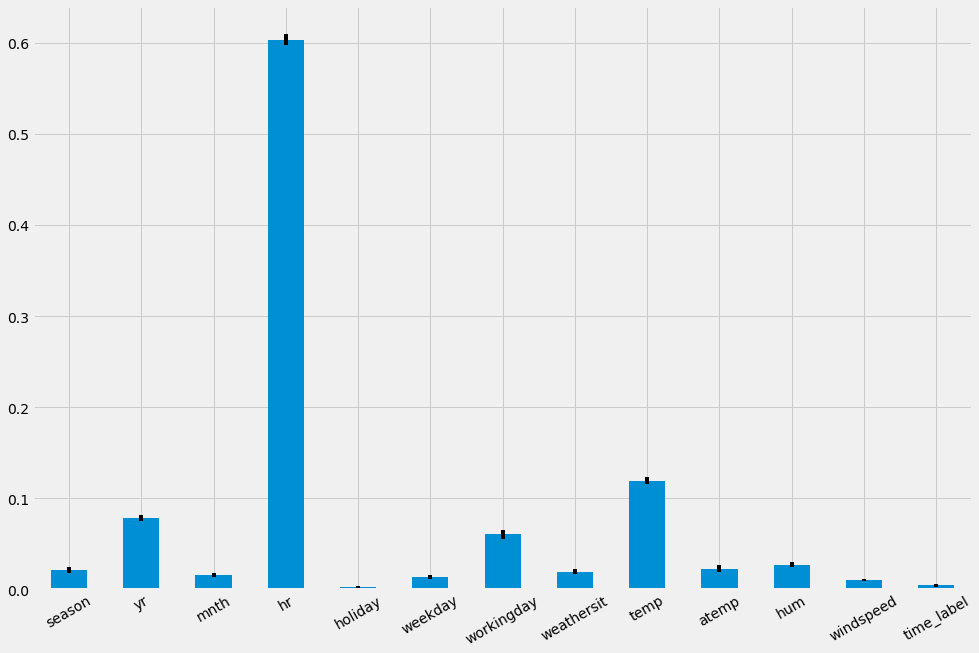

In [42]:
fig, ax = plt.subplots(figsize=(15,10))
importances.plot.bar(yerr=std, ax=ax, rot=30)

plt.show()

In [129]:
rfr = RandomForestRegressor(n_jobs=-2, n_estimators=100)

leaf_lim = range(1550, 1700, 1)
samples_split = range(2, 4)
samples_leaf = range(2, 4)
param_grid = {'max_leaf_nodes': leaf_lim, 
'min_samples_split': samples_split,
'min_samples_leaf': samples_leaf
}

gs = RandomizedSearchCV(estimator=rfr, param_distributions=param_grid, scoring='neg_mean_squared_error', n_jobs=-2)

pickle_file = './grid-search-results-1.pkl'
with open(pickle_file, 'wb') as f:
    gs.fit(train[features], train['cnt'])
    joblib.dump(gs, f)

best_file = './best-1.pkl'
best = [gs.best_params_, gs.best_estimator_, gs.cv_results_]
with open(pickle_file, 'wb') as f:
    joblib.dump(best, f)
    
# features

In [135]:
rfr = RandomForestRegressor(n_jobs=-2, n_estimators=100)

leaf_lim = range(1600, 1700, 5)
samples_split = range(2, 4)
samples_leaf = range(2, 4)
param_grid = {'max_leaf_nodes': leaf_lim, 
'min_samples_split': samples_split,
'min_samples_leaf': samples_leaf
}

gs = GridSearchCV(estimator=rfr, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-2)

pickle_file = './grid-search-results-2.pkl'
with open(pickle_file, 'wb') as f:
    gs.fit(train[features], train['cnt'])
    joblib.dump(gs, f)

best_file = './best-2.pkl'
best = [gs.best_params_, gs.best_estimator_, gs.cv_results_]
with open(best_file, 'wb') as f:
    joblib.dump(best, f)
    
# features

In [136]:
best_params, best_est, cv_results = joblib.load(best_file)
best_rfr = joblib.load(pickle_file)

In [137]:
importances = pd.Series(best_est.feature_importances_, index=best_est.feature_names_in_)
std = pd.Series(np.array([tree.feature_importances_ for tree in best_est.estimators_]).std(axis=0), 
index=best_est.feature_names_in_
)
importances.sort_values(ascending=False)

hr            0.613706
temp          0.118302
yr            0.080341
workingday    0.060315
hum           0.024952
season        0.021664
atemp         0.020743
weathersit    0.018398
mnth          0.014201
weekday       0.012564
windspeed     0.007977
time_label    0.004533
holiday       0.002303
dtype: float64

In [138]:
print('Best Parameters: {}'.format(best_params))
print('Best MSE: {:.3f}'.format(-best_rfr.best_score_))

Best Parameters: {'max_leaf_nodes': 1690, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best MSE: 1879.142


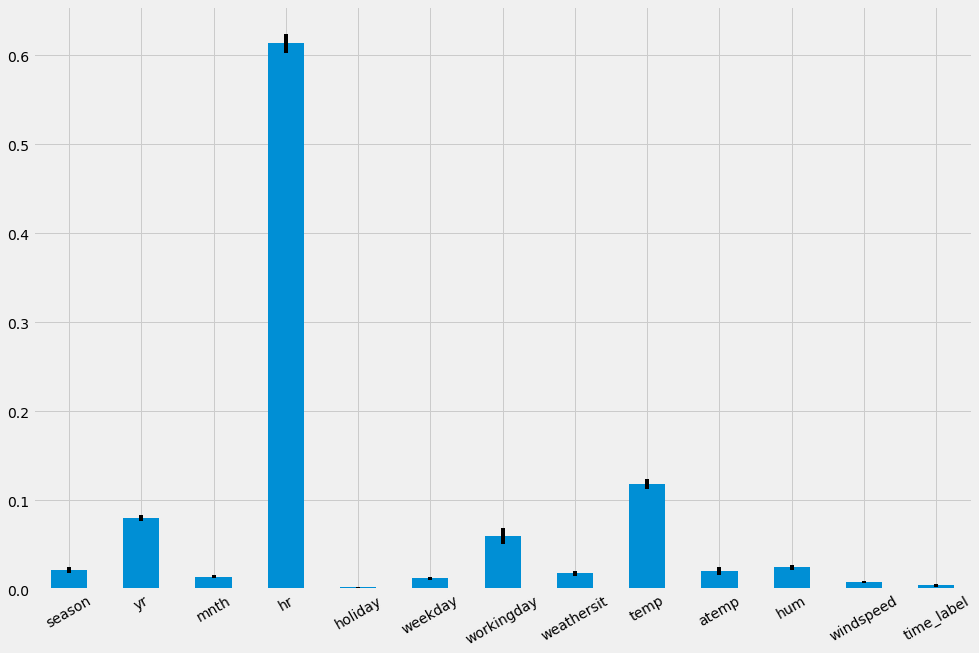

In [139]:
fig, ax = plt.subplots(figsize=(15,10))
importances.plot.bar(yerr=std, ax=ax, rot=30)

plt.show()